# MNIST GAN Training Demo

This notebook demonstrates training a DCGAN on MNIST digits.

The architecture features:
- **Generator**: 100-dim latent -> 3x3x112 projection -> TransConv layers -> 28x28x1
- **Discriminator**: 28x28x1 -> Conv layers -> single logit
- **Training**: TTUR with 10:1 G/D learning rate ratio, exponential LR decay

In [1]:
import sys
sys.path.insert(0, '..')

import matplotlib.pyplot as plt
import tensorflow as tf

from src import GANTrainer, display_image_grid, print_device_info
from src import NotebookImageCallback, ProgressCallback

# Show device configuration
print_device_info()
print()

Platform: Darwin (arm64)
TensorFlow: 2.18.0
GPU: Apple Metal (1 device(s))
Training will use GPU acceleration



## 1. Initialize Trainer

Create the trainer with MATLAB-matched hyperparameters.

In [ ]:
# Create trainer (values shown are defaults - adjust as needed)
trainer = GANTrainer(
    batch_size=250,
    epochs=50,
    g_learning_rate=0.0001,
    d_learning_rate=0.0001,
    lr_decay_rate=1.00,
    lr_decay_steps=1000,
    latent_dim=100,
    output_dir='../outputs/generated_samples'
)

print(f"Batch size: {trainer.batch_size}")
print(f"Epochs: {trainer.epochs}")
print(f"G learning rate: {trainer.g_learning_rate}")
print(f"D learning rate: {trainer.d_learning_rate}")
print(f"LR decay: {trainer.lr_decay_rate} every {trainer.lr_decay_steps} steps")

## 2. Load Data

Load and preprocess MNIST. Images are normalized to [-1, 1] to match tanh output.

Batch shape: (250, 28, 28, 1)
Value range: [-1.00, 1.00]


2026-01-17 20:55:11.001299: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M4 Max
2026-01-17 20:55:11.001322: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 128.00 GB
2026-01-17 20:55:11.001327: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 48.00 GB
I0000 00:00:1768683311.001342  850562 pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
I0000 00:00:1768683311.001357  850562 pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)
2026-01-17 20:55:11.066259: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


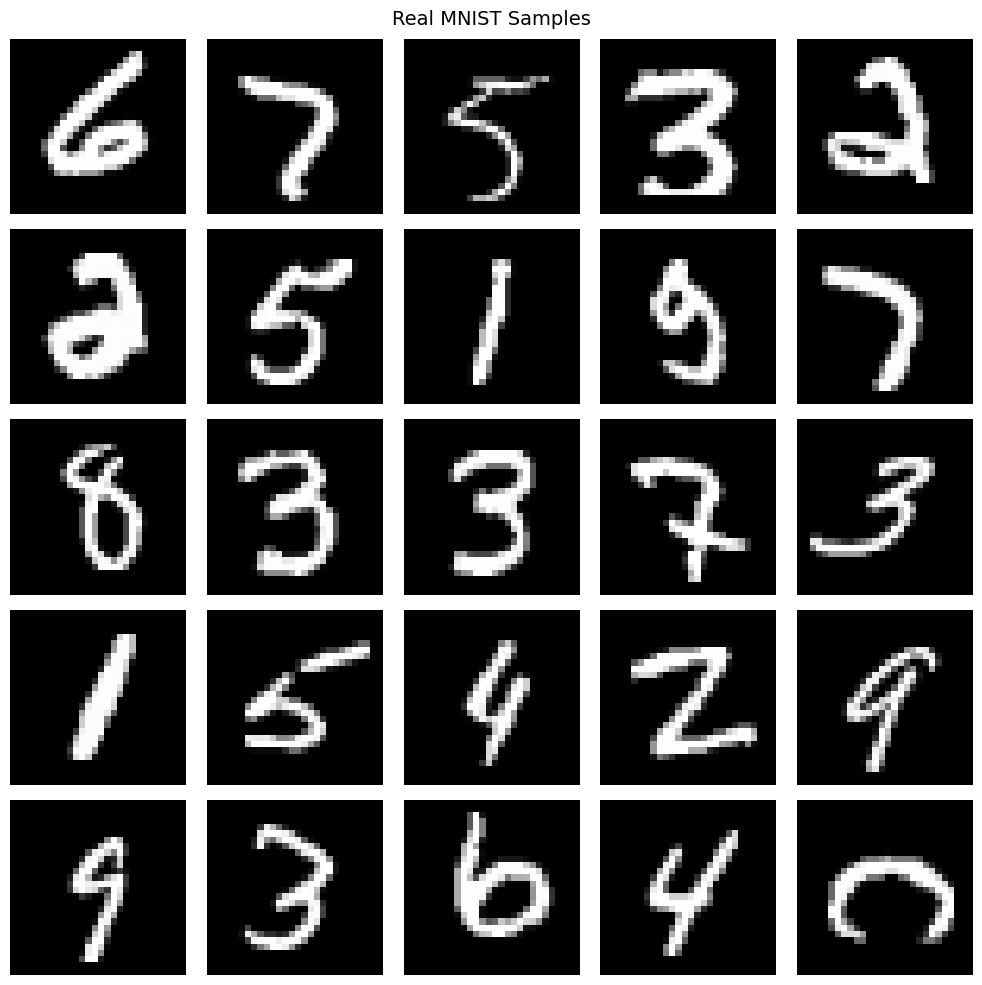

In [3]:
# Load MNIST data
dataset = trainer.load_data()

# Show dataset info
for batch in dataset.take(1):
    print(f"Batch shape: {batch.shape}")
    print(f"Value range: [{batch.numpy().min():.2f}, {batch.numpy().max():.2f}]")

# Display sample real images
sample_batch = next(iter(dataset))
fig = display_image_grid(sample_batch[:25], title="Real MNIST Samples")
plt.show()

## 3. Build Model

Create and compile the GAN with Generator and Discriminator.

In [4]:
# Build and compile the model
model = trainer.build_model()

print("\n=== Generator Architecture ===")
model.generator.summary()

print("\n=== Discriminator Architecture ===")
model.discriminator.summary()


=== Generator Architecture ===


Model: "Generator"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ proj_dense (Dense)              │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ proj_reshape (Reshape)          │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ tconv1 (Conv2DTranspose)        │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bnorm1 (BatchNormalization)     │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ tconv2 (Conv2DTranspose)        │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bnorm2 (BatchNormalization)     │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ tconv3 (Conv2DTranspose)        │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)


=== Discriminator Architecture ===


Model: "Discriminator"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1 (Conv2D)                  │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout1 (Dropout)              │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2 (Conv2D)                  │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout2 (Dropout)              │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output (Dense)                  │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

## 4. Test Forward Pass

Verify the model works before training.

In [5]:
# Test generator
z = tf.random.normal((5, 100))
fake_images = model.generator(z, training=False)
print(f"Generator output shape: {fake_images.shape}")
print(f"Generator output range: [{fake_images.numpy().min():.3f}, {fake_images.numpy().max():.3f}]")

# Test discriminator
real_batch = next(iter(dataset))[:5]
real_logits = model.discriminator(real_batch, training=False)
fake_logits = model.discriminator(fake_images, training=False)
print(f"\nDiscriminator output shape: {real_logits.shape}")
print(f"Real image logits: {real_logits.numpy().flatten()}")
print(f"Fake image logits: {fake_logits.numpy().flatten()}")

Generator output shape: (5, 28, 28, 1)
Generator output range: [-0.022, 0.029]

Discriminator output shape: (5, 1)
Real image logits: [0.01764518 0.0379793  0.04282406 0.07235532 0.06208647]
Fake image logits: [0.00017114 0.00023283 0.00014957 0.0003449  0.00011384]


## 5. Train the GAN

Train with progress visualization. Generated samples are saved to `outputs/generated_samples/`.

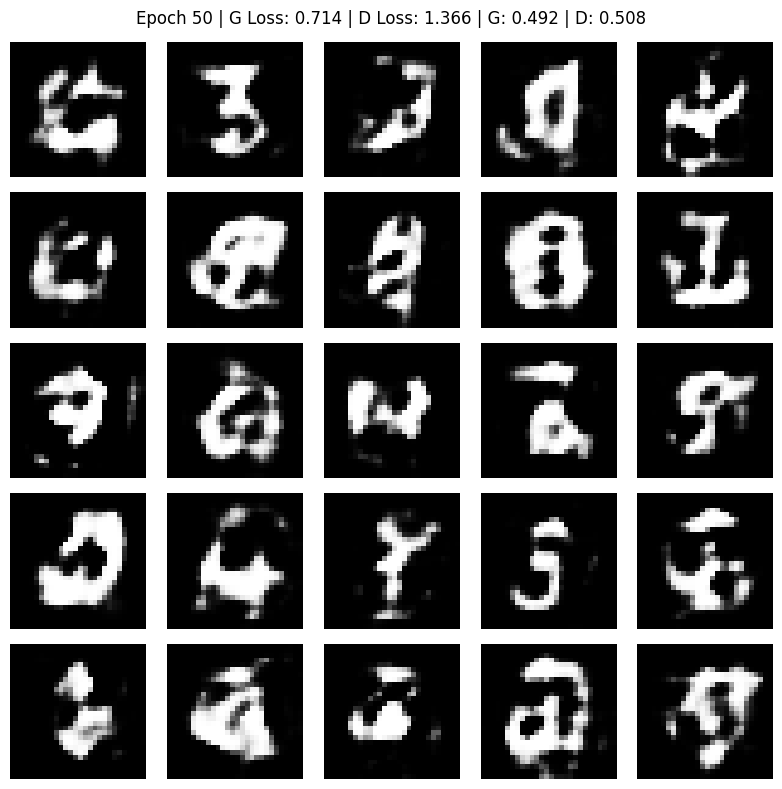


Epoch 50 Summary: G Loss=0.7143, D Loss=1.3665


In [6]:
# Set up callbacks
callbacks = [
    NotebookImageCallback(num_samples=25, latent_dim=100),  # Updates image each epoch
    ProgressCallback(print_frequency=50)  # Print progress every so many batches
]

# Train
print("Starting training...")
print(f"Training for {trainer.epochs} epochs")
print(f"Batches per epoch: {len(trainer.train_dataset)}")
print("="*50)

history = trainer.train(callbacks=callbacks, verbose=0)

## 6. Training Results

Visualize loss curves and generated samples.

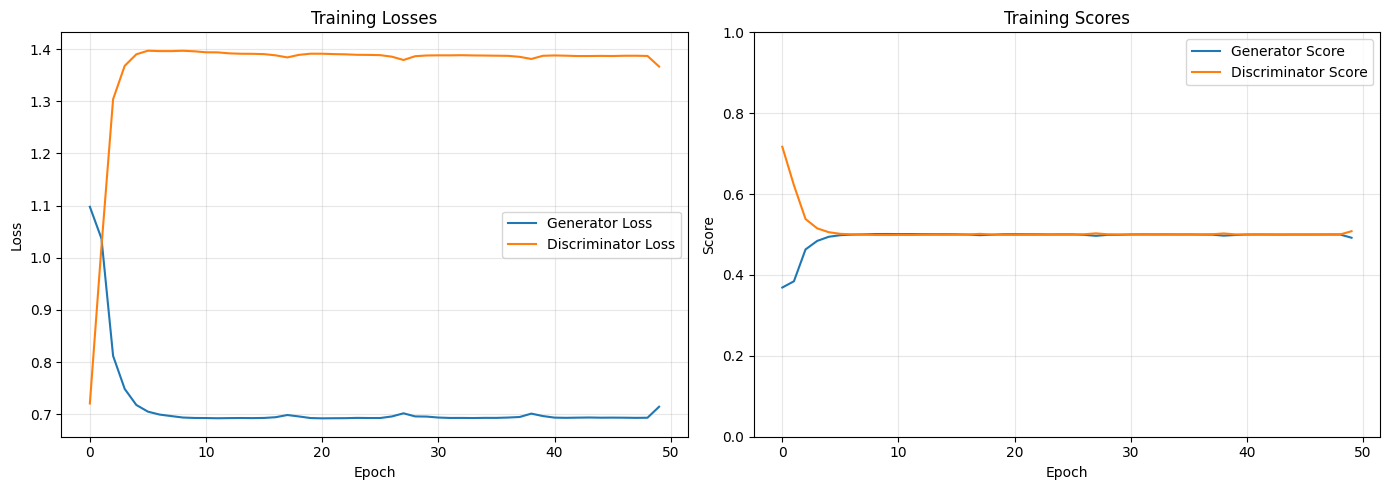

In [7]:
# Plot training history
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Loss plot
axes[0].plot(history.history['g_loss'], label='Generator Loss')
axes[0].plot(history.history['d_loss'], label='Discriminator Loss')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Loss')
axes[0].set_title('Training Losses')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Score plot
axes[1].plot(history.history['g_score'], label='Generator Score')
axes[1].plot(history.history['d_score'], label='Discriminator Score')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Score')
axes[1].set_title('Training Scores')
axes[1].legend()
axes[1].grid(True, alpha=0.3)
axes[1].set_ylim([0, 1])

plt.tight_layout()
plt.show()

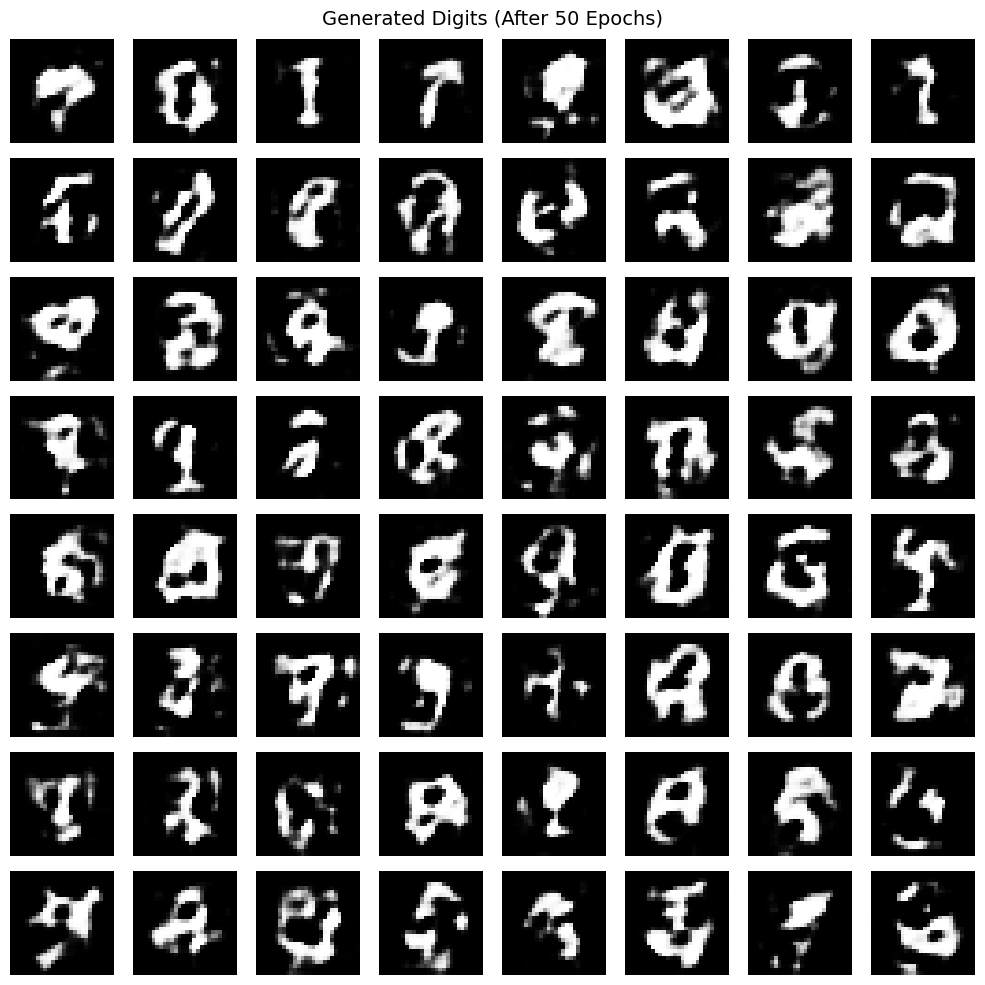

In [15]:
# Generate final samples
final_samples = trainer.generate_samples(num_samples=64)

fig = display_image_grid(
    final_samples,
    title=f"Generated Digits (After {trainer.epochs} Epochs)"
)
plt.show()

## 7. Interactive Generation

Generate new samples with different random seeds.

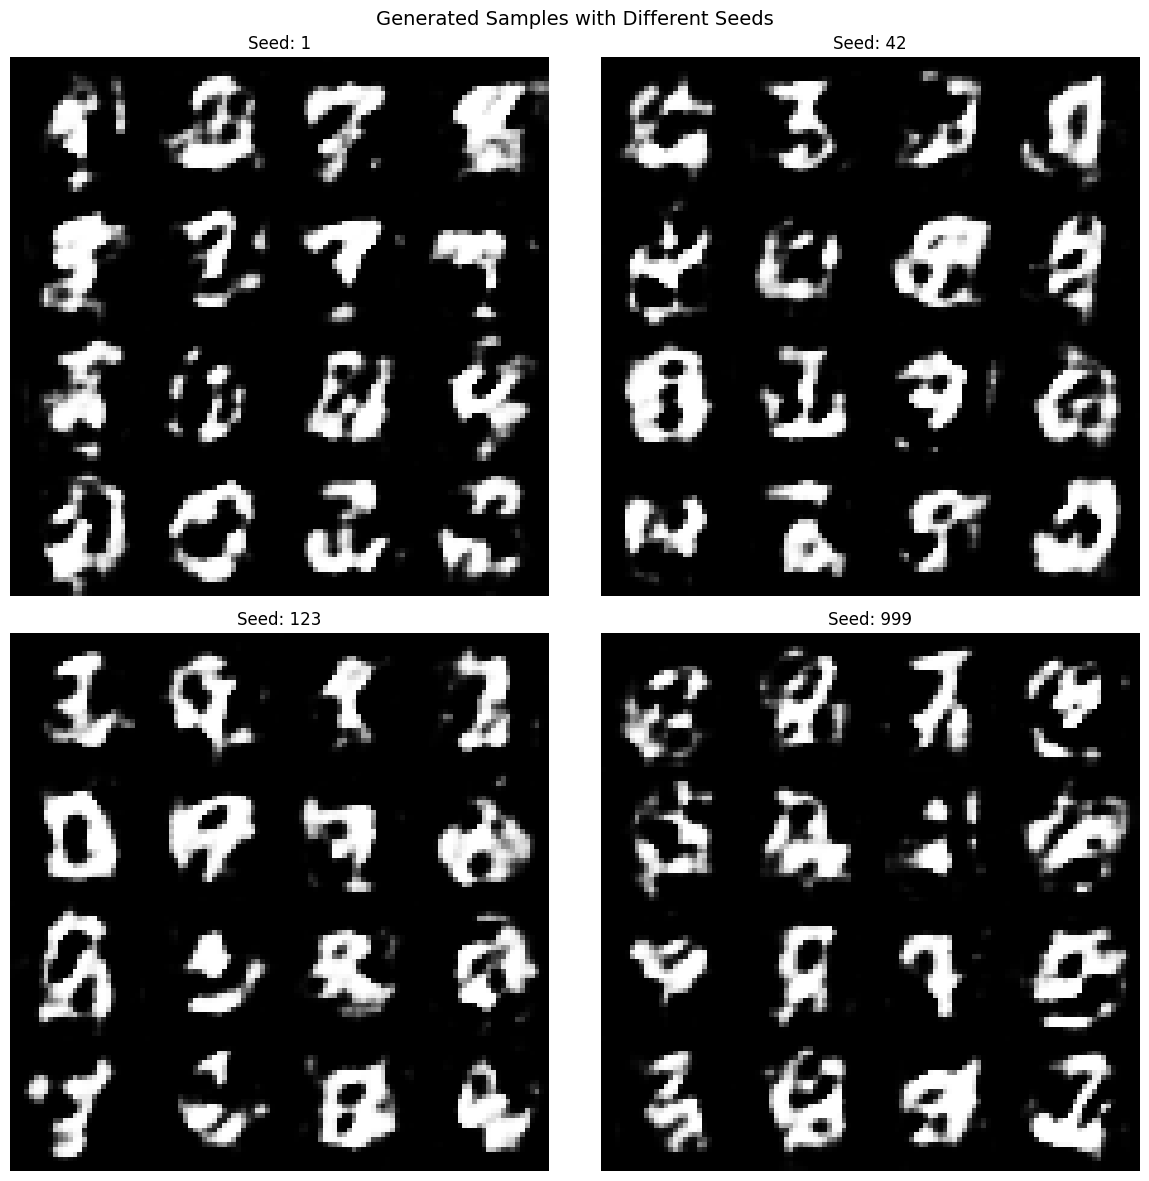

In [12]:
# Generate multiple batches with different seeds
fig, axes = plt.subplots(2, 2, figsize=(12, 12))

for idx, (ax, seed) in enumerate(zip(axes.flatten(), [1, 42, 123, 999])):
    samples = trainer.generate_samples(num_samples=16, seed=seed)
    samples_np = (samples.numpy() + 1) / 2  # Rescale to [0, 1]
    
    # Create 4x4 grid
    grid = samples_np.reshape(4, 4, 28, 28).transpose(0, 2, 1, 3).reshape(112, 112)
    
    ax.imshow(grid, cmap='gray')
    ax.set_title(f'Seed: {seed}')
    ax.axis('off')

plt.suptitle('Generated Samples with Different Seeds', fontsize=14)
plt.tight_layout()
plt.show()

## 8. Latent Space Interpolation

Interpolate between two latent vectors to see smooth transitions.

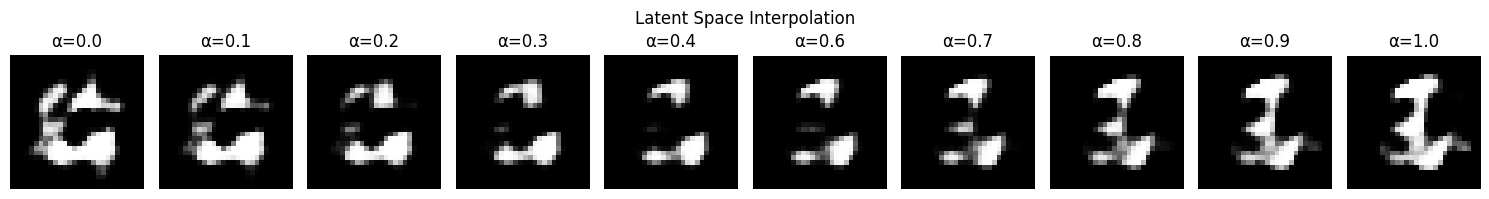

In [10]:
import numpy as np
from src import sample_latent_vectors

# Sample two random latent vectors
z1 = sample_latent_vectors(1, seed=42)
z2 = sample_latent_vectors(1, seed=123)

# Interpolate
num_steps = 10
alphas = np.linspace(0, 1, num_steps)
z_interp = tf.stack([z1[0] * (1 - a) + z2[0] * a for a in alphas])

# Generate interpolated images
interp_images = model.generate_from_latent(z_interp)

# Display
fig, axes = plt.subplots(1, num_steps, figsize=(15, 2))
for i, ax in enumerate(axes):
    img = (interp_images[i].numpy() + 1) / 2
    ax.imshow(img[:, :, 0], cmap='gray')
    ax.axis('off')
    ax.set_title(f'α={alphas[i]:.1f}')

plt.suptitle('Latent Space Interpolation', fontsize=12)
plt.tight_layout()
plt.show()